<a href="https://colab.research.google.com/github/Ralls0/logocGAN/blob/ral%2Fbup/logocGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np


In [ ]:
# mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow import keras

# Model definition

In [ ]:
def build_generator(width, height, inputDim=100, n1=2048, channels=3):

  inp = Input(shape=(inputDim,))

  # FC - BN 
  dim1 = width // 16     # because we have 4 transpose conv layers with strides 2 -> 
                        # -> we are upsampling by a factor of 64
  dim2 = height // 16
  
  x = Dense( dim1 * dim2 * n1, activation="relu")(inp)
  x = BatchNormalization()(x)
  #x = Activation("relu")(x)

  # Reshape to width * heigh * feature_channels

  x = Reshape((dim1, dim2,n1))(x)

  # alternative formulation: batchnorm before activation
  #x = Conv2DTranspose(n1//2, (5, 5), strides=(2, 2), padding="same")(x)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)

  #x = Conv2DTranspose(n1//4, (5, 5), strides=(2, 2), padding="same")(x)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)
  #x = Conv2DTranspose(n1//8, (5, 5), strides=(2, 2), padding="same")(x)
  #x = BatchNormalization()(x)
  #x = Activation("relu")(x)

 
  # now add conv 2D transpose
  x = Conv2DTranspose(n1//2, (5, 5), strides=(2, 2), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(n1//4, (5, 5), strides=(2, 2), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(n1//8, (5, 5), strides=(2, 2), padding="same", activation="relu")(x)
  x = BatchNormalization()(x)

  
  # now add final layer with tanh activation
  out = Conv2DTranspose(channels, (5,5), strides=(2,2), padding="same", activation="tanh")(x)

  m = Model(inputs=inp, outputs=out)
  return m

  

In [ ]:
NUM_DIMS=100
image_size = (256,256)
gen = build_generator(image_size[0], image_size[1], inputDim=NUM_DIMS, n1=2048, channels=3)

gen.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 524288)            52953088  
                                                                 
 batch_normalization_8 (Batc  (None, 524288)           2097152   
 hNormalization)                                                 
                                                                 
 reshape_2 (Reshape)         (None, 16, 16, 2048)      0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 32, 32, 1024)     52429824  
 ranspose)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 1024)     4096

In [ ]:
# builds a discriminator with 3 convolutional layers


def build_discriminator(width, height, channels, alpha=0.2, droprate=0.4):
    input_shape = (width, height, channels)

    # use Leaky ReLU instead of Relu in the discriminator
    leaky = tf.keras.layers.LeakyReLU(alpha)
    n1 = 128
    n2 = 256
    n3 = 512

    inp = Input(shape=input_shape)
    x = Conv2D(n1, (5,5), strides=(2,2), activation=leaky)(inp)
    #x = MaxPooling2D(strides=2)(x)
    x = Conv2D(n2, (5,5), strides=(2,2), activation=leaky)(x)
    #x = MaxPooling2D(strides=2)(x)
    x = Conv2D(n3, (3,3), strides=(2,2), activation=leaky)(x)
   # x = MaxPooling2D(strides=2)(x)
   
    x = Flatten()(x)
   # x = Dense(n3/8, activation=leaky)(x)

    #use dropout to increase variability in the discriminator
    x = Dropout(droprate)(x)
    out = Dense(1, activation="sigmoid")(x)

    m = Model(inputs=inp, outputs=out)
    return m


    


   

In [ ]:
disc = build_discriminator(image_size[0], image_size[1], 3, droprate=0.5)
disc.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 128)     9728      
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 256)       819456    
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 512)       1180160   
                                                                 
 flatten_2 (Flatten)         (None, 460800)            0         
                                                                 
 dropout_2 (Dropout)         (None, 460800)            0         
                                                                 
 dense_5 (Dense)             (None, 1)                 4608

In [ ]:
# now compile the discriminator
INIT_LR=2e-4
# Adam with lower values of beta_1 was found to achieve best performances for different GANs architecture
# GANs are quite sensitive to the learning rate
discOpt = tf.keras.optimizers.Adam(lr=INIT_LR, beta_1=0.5)
disc.compile(discOpt, loss="binary_crossentropy", metrics=["accuracy"])
disc.summary()






Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 128)     9728      
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 256)       819456    
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 512)       1180160   
                                                                 
 flatten_2 (Flatten)         (None, 460800)            0         
                                                                 
 dropout_2 (Dropout)         (None, 460800)            0         
                                                                 
 dense_5 (Dense)             (None, 1)                 4608

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:

# now connect the two models

# first set the discriminator to not trainable
disc.trainable = False
noise = Input((NUM_DIMS))
# connect the discriminator with the generator
# alternatively, you can define a sequential model with the generator and discriminator as layers
discOutput=disc(gen(noise))
gan = Model(inputs=noise, outputs=discOutput)

#use a learning rate equal or lower for the generator
ganOpt = tf.keras.optimizers.Adam(lr=INIT_LR, beta_1=0.5)
gan.compile(loss="binary_crossentropy", optimizer=ganOpt)

gan.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_6 (Functional)        (None, 256, 256, 3)       123891203 
                                                                 
 model_7 (Functional)        (None, 1)                 2470145   
                                                                 
Total params: 126,361,348
Trainable params: 122,839,043
Non-trainable params: 3,522,305
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
disc.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 128)     9728      
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 256)       819456    
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 512)       1180160   
                                                                 
 flatten_2 (Flatten)         (None, 460800)            0         
                                                                 
 dropout_2 (Dropout)         (None, 460800)            0         
                                                                 
 dense_5 (Dense)             (None, 1)                 4608

# Now define the random noise generator




In [ ]:
# function to generate random points in the latent space
# in this case, we are using a Gaussian (normal) distribution with 0 mean and 1. std
def generate_latent_points(latent_dim, n_samples):

	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# noise vector used during training in order to evaluate how the network is learning
BATCH_SIZE=64
benchmarkNoise = generate_latent_points(NUM_DIMS, BATCH_SIZE)

# Now define the data loading generator


In [ ]:
# preprocess the images so that they are in the range [-1, 1]
# the range of the real images should be the same of the fake images 

def preprocessing_function(x):
  return (x - 127.5)/127.5


# add some data augmentation since the dataset size is small
train_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,  
    vertical_flip=False,  
    rescale=None,
    preprocessing_function=preprocessing_function
)



In [ ]:
directory="/content/drive/MyDrive/Politecnico/logo"
directory_models="/content/drive/MyDrive/Politecnico/gen/"
import os
import cv2
training_size = len(os.listdir(directory+"/1") )
print(training_size)

1940


In [ ]:

train = train_generator.flow_from_directory(directory, target_size=image_size, batch_size=BATCH_SIZE, shuffle=True)

Found 1940 images belonging to 1 classes.


#Now train for a given number of epochs



In [ ]:
from sklearn.utils import shuffle
from imutils import build_montages

import matplotlib.pyplot as plt
from tqdm import tqdm

from datetime import datetime


In [ ]:
# utility function to plot some figures
def plot_figures(x, n, figsize=None):
  if figsize:
      plt.figure(figsize=figsize)
  for i in range(n*n):
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      img=x[i,:,:,:]
      # rescale for visualization purposes
      img = ((img*127.5) + 127.5).astype("uint8")
      plt.imshow(img)
    
  plt.show()

In [ ]:
def store_figures(x, n, directory, epoch):
  for i in range(n*n):
    img=x[i,:,:,:]
    cv2.imwrite(os.path.join(directory, "dcgan_img_gen-" + str(epoch) + "-" + str(i) + ".png"), img)

In [ ]:
trueImages, _ = next(train)
trueImages.shape

(64, 256, 256, 3)

In [ ]:
batchesPerEpoch = int(training_size / BATCH_SIZE)
print(batchesPerEpoch)

30


In [ ]:
BATCH_SIZE_2 = BATCH_SIZE // 2
NUM_EPOCHS=300

history = {}
#keep track of loss and accuracy separately for true and fake images
history['G_loss'] = []
history['D_loss_true'] = []
history['D_loss_fake'] = []
accuracy = {}
accuracy['Acc_true'] = []
accuracy['Acc_fake'] = []
# for each epoch
for epoch in range(NUM_EPOCHS):
     now = datetime.now()
     current_time = now.strftime("%H:%M:%S")
     print(f"[i] ({current_time}) Epoch {epoch}")
     batchesPerEpoch = int(training_size / BATCH_SIZE)

     # for each batch
     for b in (range(batchesPerEpoch)):
       now = datetime.now()
       current_time = now.strftime("%H:%M:%S")
       print(f"\t[+] ({current_time}) Batch {b}")
       # now train the discriminator to differentiate between true and fake images
       trueImages, _ = next(train)
       # one sided label smoothing reduces overconfidence in true images and stabilizes training a bit

       y = 0.9*np.ones((trueImages.shape[0]))
       discLoss, discAcc = disc.train_on_batch(trueImages, y)
       history['D_loss_true'].append(discLoss)          
       # warning: accuracy will not be calculated if label smoothing is used 
       accuracy['Acc_true'].append(discAcc)
       
       # generate some fake samples
       noise =  generate_latent_points(NUM_DIMS, BATCH_SIZE)
       genImages=gen.predict(noise)
       y = np.zeros((BATCH_SIZE))
      
       discLoss, discAcc = disc.train_on_batch(genImages, y)
       history['D_loss_fake'].append(discLoss)          
       accuracy['Acc_fake'].append(discAcc)

       # mixing true and fake samples (like below) may prevent training, especially when using batch normalization
       #X =  np.concatenate((trueImages, genImages))
       #y = np.concatenate((np.ones((BATCH_SIZE_2)), np.zeros((BATCH_SIZE_2))))
       #(X, y) = shuffle(X, y)
       #discLoss, discAcc = disc.train_on_batch(X, y)
       #history['D_loss'].append(discLoss)
      
       # now train the generator
       noise =  generate_latent_points(NUM_DIMS, BATCH_SIZE)
       # some authors suggest randomly flipping some labels to introduce random variations
       fake_labels = [1] * BATCH_SIZE
       fake_labels = np.reshape(fake_labels, (-1,))
       ganLoss = gan.train_on_batch(noise, fake_labels)
       
       history['G_loss'].append(ganLoss)
 
     # at the end of each epoc  
     print("epoch " + str(epoch) + ": discriminator loss " + str(discLoss)+  " ( "  + str(discAcc) + " ) - generator loss" + str(ganLoss))

     # it is important to regularly visualize the output
     images = gen.predict(benchmarkNoise)
     store_figures(images, 4, directory_models, epoch)
     plot_figures(images, 4)


     # save regularly as the training may destabilize and start producing garbage image again
     if (epoch % 100) == 0:
        gan.save(os.path.join(directory_models, "dcgan_2" + str(epoch)+".h5"))
    


NameError: ignored

In [ ]:
import pandas
def plot_losses(history, lim):
  pandas.DataFrame(history).plot(figsize=(10,8))
  plt.grid(True)
  plt.gca().set_ylim(0,lim)
  plt.show()

In [ ]:
plot_losses(history, 3)
plot_losses(accuracy, 1)

In [ ]:
plot_figures(trueImages,4,figsize=(10,10))

In [ ]:
#reload the model at the selecte epoch

epoch = 200
leaky = tf.keras.layers.LeakyReLU(0.2)
tf.keras.utils.get_custom_objects().update({'LeakyReLU': leaky})
gan = tf.keras.models.load_model(os.path.join(directory_models, "dcgan_2" + str(epoch)+".h5"))

gen = gan.layers[1]

gen.summary()

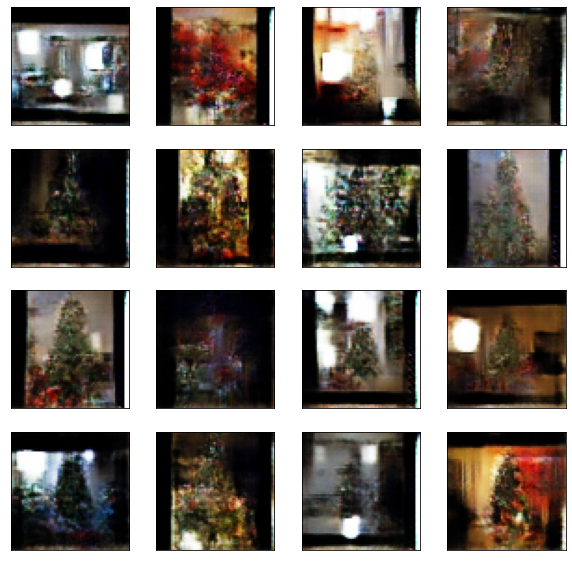

In [ ]:
noisevector = generate_latent_points(NUM_DIMS, BATCH_SIZE)

genImages = gen.predict(noisevector)    
plot_figures(genImages,4, figsize=(10,10))